# Statistical properties of Volatility Arbitrage Strategies

## Introduction

Volatility arbitrage is a trading strategy that attempts to profit from the difference between the forecasted future realized volatility and the implied volatility of an option. The strategy involves buying options when the implied volatility is cheap relative to the forecasted volatility, and selling options when the implied volatility is expensive. It should be said that forecasting volatility is a difficult task. There are many approaches to it [here](https://github.com/akaufman22/FXVolStatArb) and [here](https://github.com/akaufman22/FinanceNoteboks/blob/main/FXVolatilityRiskPremium/FXVRP.ipynb). In this notebook, I will focus on strategies monetizing the forecast rather than the forecast itself.

In order to isolate the volatility component of the option price, the strategy typically involves delta hedging the option position. This means that the trader will buy or sell the underlying asset in order to offset the directional risk of the option position. The hedge ratio is determined by the delta of the option, which measures the sensitivity of the option price to changes in the price of the underlying asset. The delta itself is a function of volatility. This means that even with the same theoretical model, the outcome of delta hedging can be different depending on whether the implied or forecasted volatility is used.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

from qftools.options import bsm_value, bsm_delta, bsm_gamma
from qftools import generate_gbm

plt.style.use("ggplot")
%matplotlib inline

Helpful procedures:

In [31]:
def delta_hedge_strategy(paths, K, T, r, q, val_vol, hedging_vol, Flag,
                         price=None):
    (n, N) = paths.shape
    maturities = np.linspace(T, 0, n)
    deltas = np.zeros([n, N])
    values = np.zeros([n, N])
    gammas = np.zeros([n, N])
    with np.errstate(divide='ignore',invalid='ignore'):
        for i, m in enumerate(maturities): 
            values[i] = bsm_value(paths[i], K, m, r, q, val_vol, Flag)
            deltas[i] = bsm_delta(paths[i], K, m, r, q, hedging_vol, Flag)
            gammas[i] = bsm_gamma(paths[i], K, m, r, q, hedging_vol)
    cash_flows = np.zeros([n, N])
    if price is None:
        cash_flows[0] = deltas[0] * paths[0] - values[0]
    else:
        cash_flows[0] = deltas[0] * paths[0] - price
    for i in range(1,n):
        cash_flows[i] = paths[i]  * (deltas[i] - deltas[i-1])
    exercise = - K * deltas[-1]
    cash_flows[-1] = cash_flows[-1] + exercise
    values[-1] = 0
    deltas[-1] = 0
    gammas[-1] = 0
    return cash_flows, values, deltas, gammas

def plot_stats(cash_flows, values, deltas, gammas,
               realised_vol, returns, benchmark_pl):
    # Final total PL for each path (vector of size N):
    total_pl = cash_flows.sum(axis=0)
    # Cumulative Daily PL (matrix of size n x N):
    cumulative_pl = cash_flows.cumsum(axis=0) + values - deltas * sample
    # Daily PL (matrix of size n x N):
    daily_pl = np.insert(np.diff(cumulative_pl, axis=0), 0, cumulative_pl[0,:], axis=0)
    # Tracking error of the delta hedging strategy (vector of size N):
    tracking_error = total_pl - benchmark_pl
    # Gamma integral for each path (vector of size N):
    gamma_integral = ((returns ** 2) * gammas[:-1]).sum(axis=0)
    # Plotting the results:
    fig, ax = plt.subplots(4, 2, figsize=(40, 20))
    ax[0, 0].hist(total_pl, bins=50, density=True)
    ax[0, 0].set_title('Histogram of total PL')
    ax[0, 1].scatter(realised_vol, total_pl, alpha=0.5)
    ax[0, 1].set_title('Total PL vs Realised Vol')
    ax[0, 1].set_xlabel('Realised Vol')
    ax[0, 1].set_ylabel('Total PL')
    ax[1, 0].hist(tracking_error, bins=50, density=True)
    ax[1, 0].set_title('Histogram of tracking error')
    ax[1, 1].scatter(gamma_integral, tracking_error, alpha=0.5)
    ax[1, 1].set_title('Tracking error vs Gamma Integral')
    ax[1, 1].set_xlabel('Gamma Integral')
    ax[1, 1].set_ylabel('Tracking error')
    ax[2, 0].plot(daily_pl.mean(axis=1))
    ax[2, 0].set_title('Daily PL mean')
    ax[2, 1].plot(daily_pl.std(axis=1))
    ax[2, 1].set_title('Daily PL standard deviation')
    ax[3, 0].plot(cumulative_pl.mean(axis=1))
    ax[3, 0].set_title('Cumulative PL mean')
    ax[3, 1].plot(cumulative_pl.std(axis=1))
    ax[3, 1].set_title('Cumulative PL standard deviation')
    fig.tight_layout()
    plt.show()
    return    


## Black-Scholes model and Delta Hedging

Consider Black-Scholes world with no market frictions. We buy (or sell) an option at its fair implied volatility level. If we dynamically delta hedge the option till maturity with constant time intervals, then on average we will realise no value as the hedging trades replicate the option.
In each individual case, P&L of delta hedging strategy may be positive or negative. This tracking error has two sources: the first is the difference between the fair volatility and the realised volatility. The former is parameter $\sigma$ from SDE for asset price, while the latter is the square root of sample variance of log returns on realised asset path. The second source is noncontinuity of delta hedging. The longer time periods between rebalancing, the larger the variance of error as the second order effect kicks in.

Consider example with following inputs describing 1 year atm call:

In [3]:
T = 1
r = 0
q = 0
sigma = 0.3
S_0 = 100
K = 100

Next I will simulate paths of asset price and daily delta hedging P&L

Simulated number of paths: 5000       Average realised volatility: 0.30       Standard deviation of realised volatility: 0.01


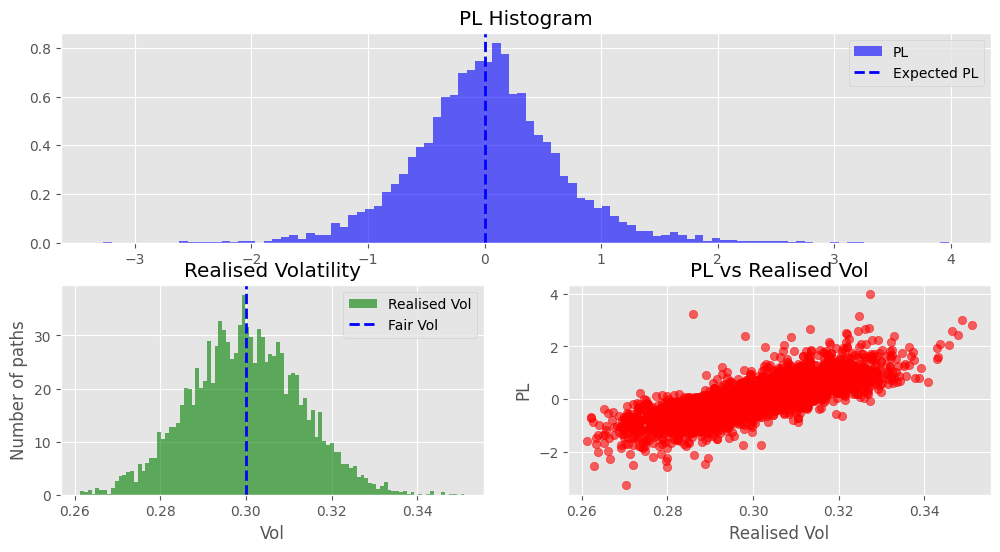

In [5]:
N = 5000
n_hedges = 260

sample = generate_gbm(T, n_hedges, r-q, sigma, S_0, N, random_state=42).T
returns = np.log(sample[:-1,]) - np.log(sample[1:,])
realised_vol = (returns).std(axis=0, ddof=1) * np.sqrt(n_hedges/T)

print(f'Simulated number of paths: {N} \
      Average realised volatility: {realised_vol.mean():.2f} \
      Standard deviation of realised volatility: {realised_vol.std():.2f}')

trading, _, _, _ = delta_hedge_strategy(sample, K, T, r, q, sigma, sigma, 0)
dh_pl = trading.sum(axis=0)

fig = plt.figure(figsize=(12, 6))
fig.tight_layout()
gridspec.GridSpec(2,2)
plt.subplot2grid((2,2), (0,0), colspan=2)
plt.hist(dh_pl, density=True, bins=100, alpha=0.6, color='b', label='PL')
plt.title("PL Histogram")
plt.axvline(0, color='b', linestyle='dashed', linewidth=2, label='Expected PL')
plt.legend()
plt.subplot2grid((2,2), (1,1))
plt.scatter(realised_vol, dh_pl, alpha=0.6, color='r')
plt.title("PL vs Realised Vol")
plt.xlabel('Realised Vol')
plt.ylabel('PL')
plt.subplot2grid((2,2), (1,0))
plt.hist(realised_vol, density=True, bins=100, alpha=0.6, color='g', label='Realised Vol')
plt.title("Realised Volatility")
plt.axvline(sigma, color='b', linestyle='dashed', linewidth=2, label='Fair Vol')
plt.ylabel("Number of paths")
plt.xlabel('Vol')
plt.legend()
plt.show()

Reducing the time interval between delta hedging trades will reduce the tracking error.

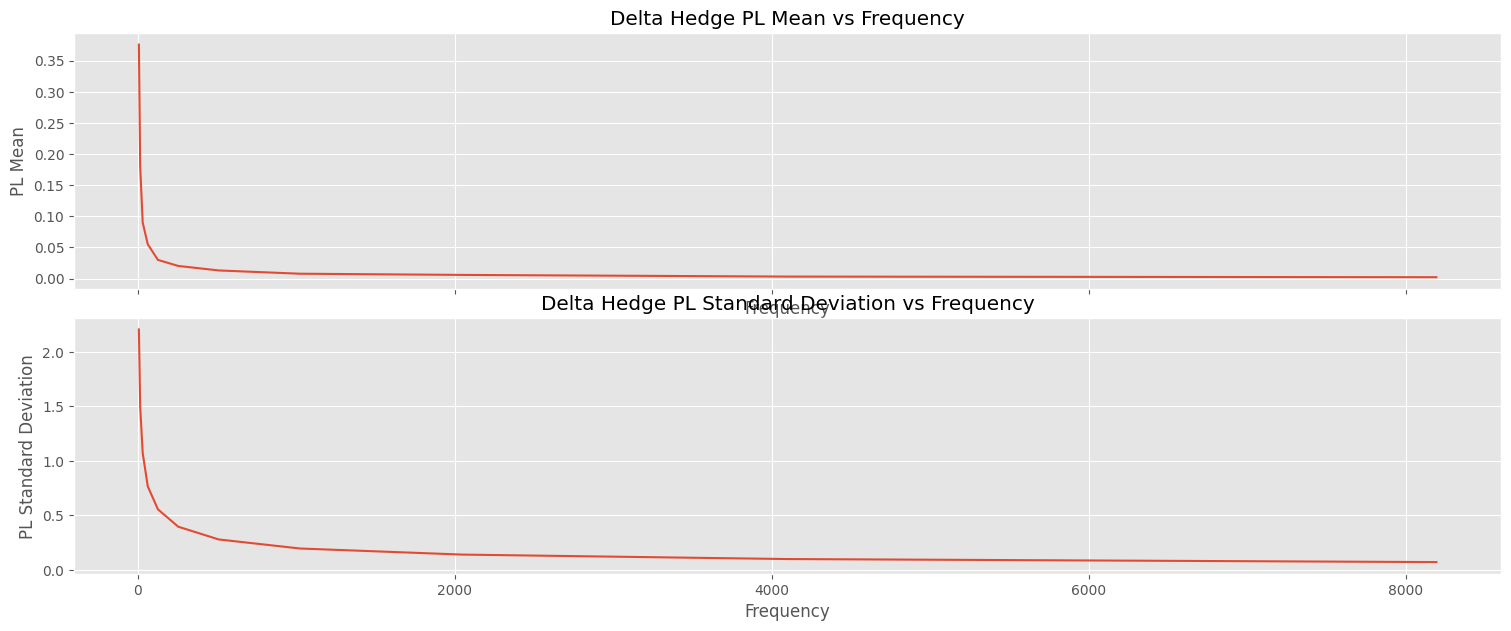

In [6]:
N = 5000
dh_stdev = []
dh_mean = []
freq = 2 ** np.linspace(3, 13, 11)
sample = generate_gbm(T, int(freq[-1]), r-q, sigma, K, N, random_state=42).T
for i in freq:
    k = int(freq[-1] / i)
    subsample = sample[::k]
    returns = np.log(subsample[:-1,]) - np.log(subsample[1:,])
    realised_vol = (returns).std(axis=0, ddof=1) * np.sqrt(i/T)
    benchmark_pl = bsm_value(S_0, K, T, r, q, realised_vol, 0) - bsm_value(S_0, K, T, r, q, sigma, 0)
    trading = (delta_hedge_strategy(subsample, K, T, r, q, sigma, sigma, 0)[0])
    bm_deviation = trading.sum(axis=0) - benchmark_pl
    dh_stdev.append(bm_deviation.std())
    dh_mean.append(bm_deviation.mean())
fig, ax = plt.subplots(2, 1, figsize=(15, 6), sharex=True)
fig.tight_layout()
ax[1].plot(freq, dh_stdev)
ax[1].set_title('Delta Hedge PL Standard Deviation vs Frequency')
ax[1].set_xlabel('Frequency')
ax[1].set_ylabel('PL Standard Deviation')
ax[0].plot(freq, dh_mean)
ax[0].set_title('Delta Hedge PL Mean vs Frequency')
ax[0].set_xlabel('Frequency')
ax[0].set_ylabel('PL Mean')
plt.show()

Example above describes a fairly priced option. Delta hedging strategy essentially replicates the opposite side of the options trade. Simulation above provides another illustration that delta hedging is consistent with the Black-Scholes model. In this perfect world, delta hedging is a very technical and boring instrument to offset the option trade on the book.

## Delta Hedging of Mispriced Options

In the real world, we do not know the actual volatility of the asset, and implied volatility is not necessarily a good forecast. Moreover, there is a lot of practical evidence and theoretical arguments that option market prices should have a material risk premium. As a result, the statistical properties of delta hedging performance may be different. Several situations are possible:
1. Baseline fairly priced option, $\sigma_{implied} = \sigma$
2. Uninformed trader (with no forecast), $\sigma_{implied} \neq \sigma$
3. Informed trader (with forecast), $\sigma_{implied} \neq \sigma$

First we simulate a number of paths:

In [32]:
# Simulated paths (matrix of size N x n_hedges)
sample = generate_gbm(T, n_hedges, r-q, sigma, S_0, N, random_state=42).T
# Log returns (matrix of size N x n_hedges - 1)
returns = np.log(sample[:-1,]) - np.log(sample[1:,])
# Realised volatility for each path (vector of size N) 
realised_vol = (returns).std(axis=0, ddof=1) * np.sqrt(n_hedges/T)

First case is fairly priced option. Parameter $\sigma$ from SDE for asset price is known and equal to implied volalatility.

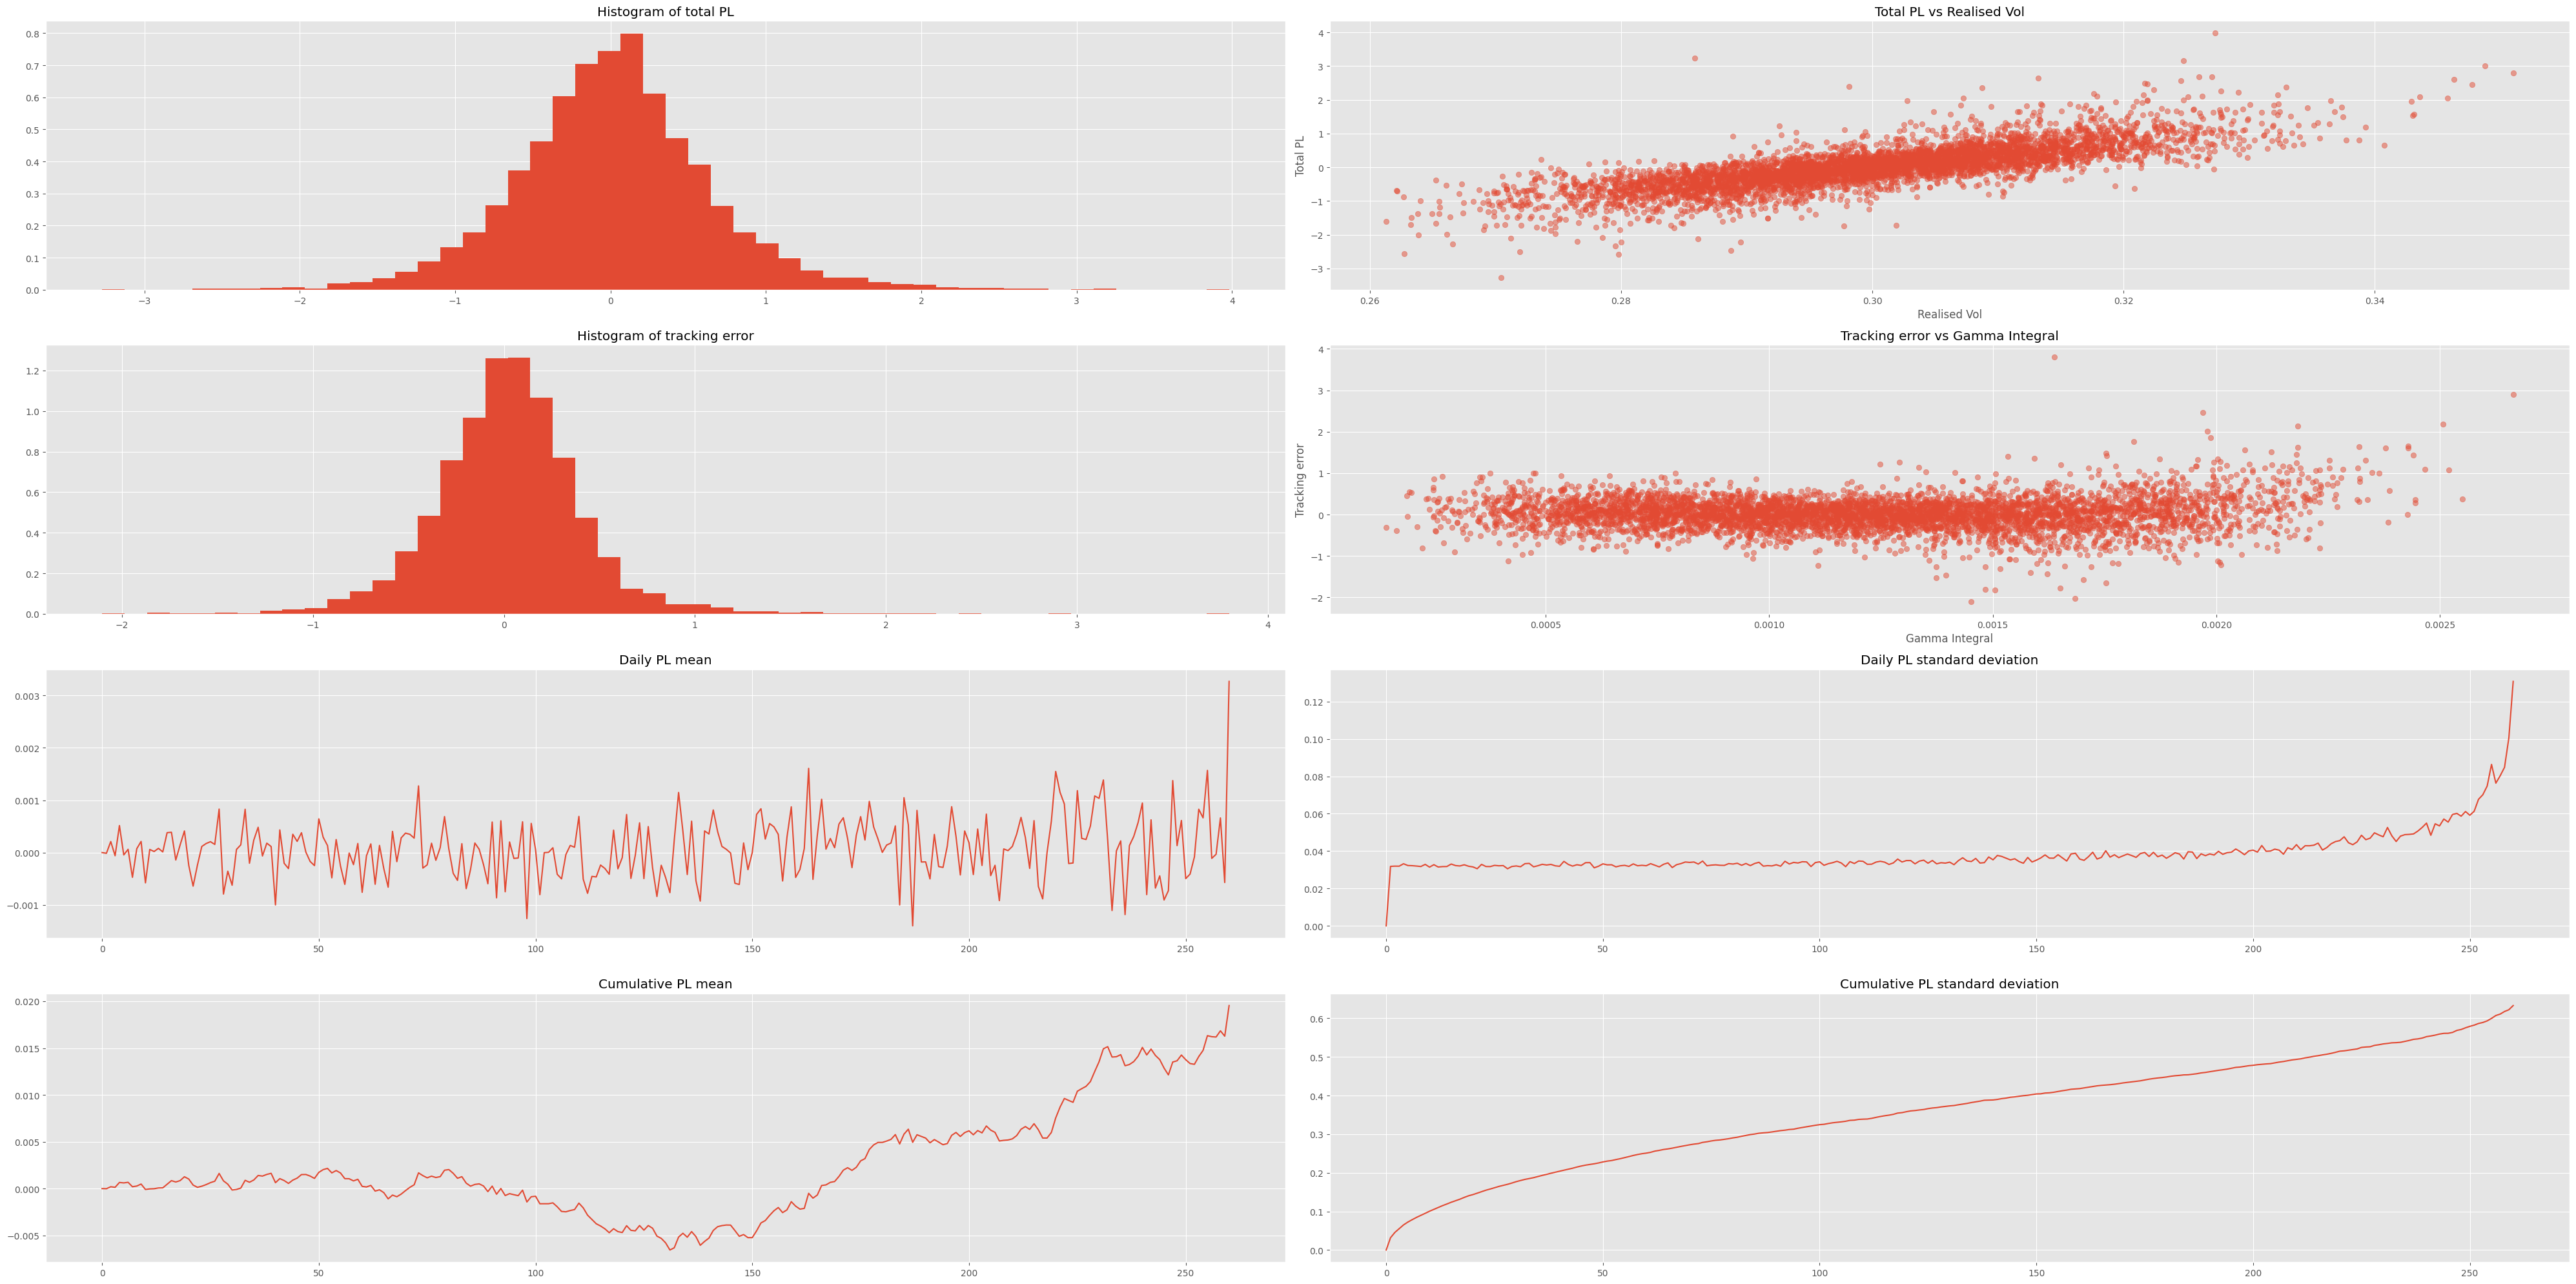

In [33]:
# Fair implied volatility assumption:
implied_vol = sigma
# Delta hedge strategy:
cash_flows, values, deltas, gammas = delta_hedge_strategy(sample, K, T, r, q, implied_vol, implied_vol, 0)
# Benchmark PL:
benchmark_pl = bsm_value(S_0, K, T, r, q, realised_vol, 0) - bsm_value(S_0, K, T, r, q, implied_vol, 0)
# Plotting the results:
plot_stats(cash_flows, values, deltas, gammas, realised_vol, returns, benchmark_pl)

In the case above the PL is simply noise around zero as it is expected for fairly priced option.

Next, we consider the case when implied volatility is different from true $\sigma$ of price generating process. We assume that delta hedger knows the true volatility and uses it for both delta hedging and valuation of the option.

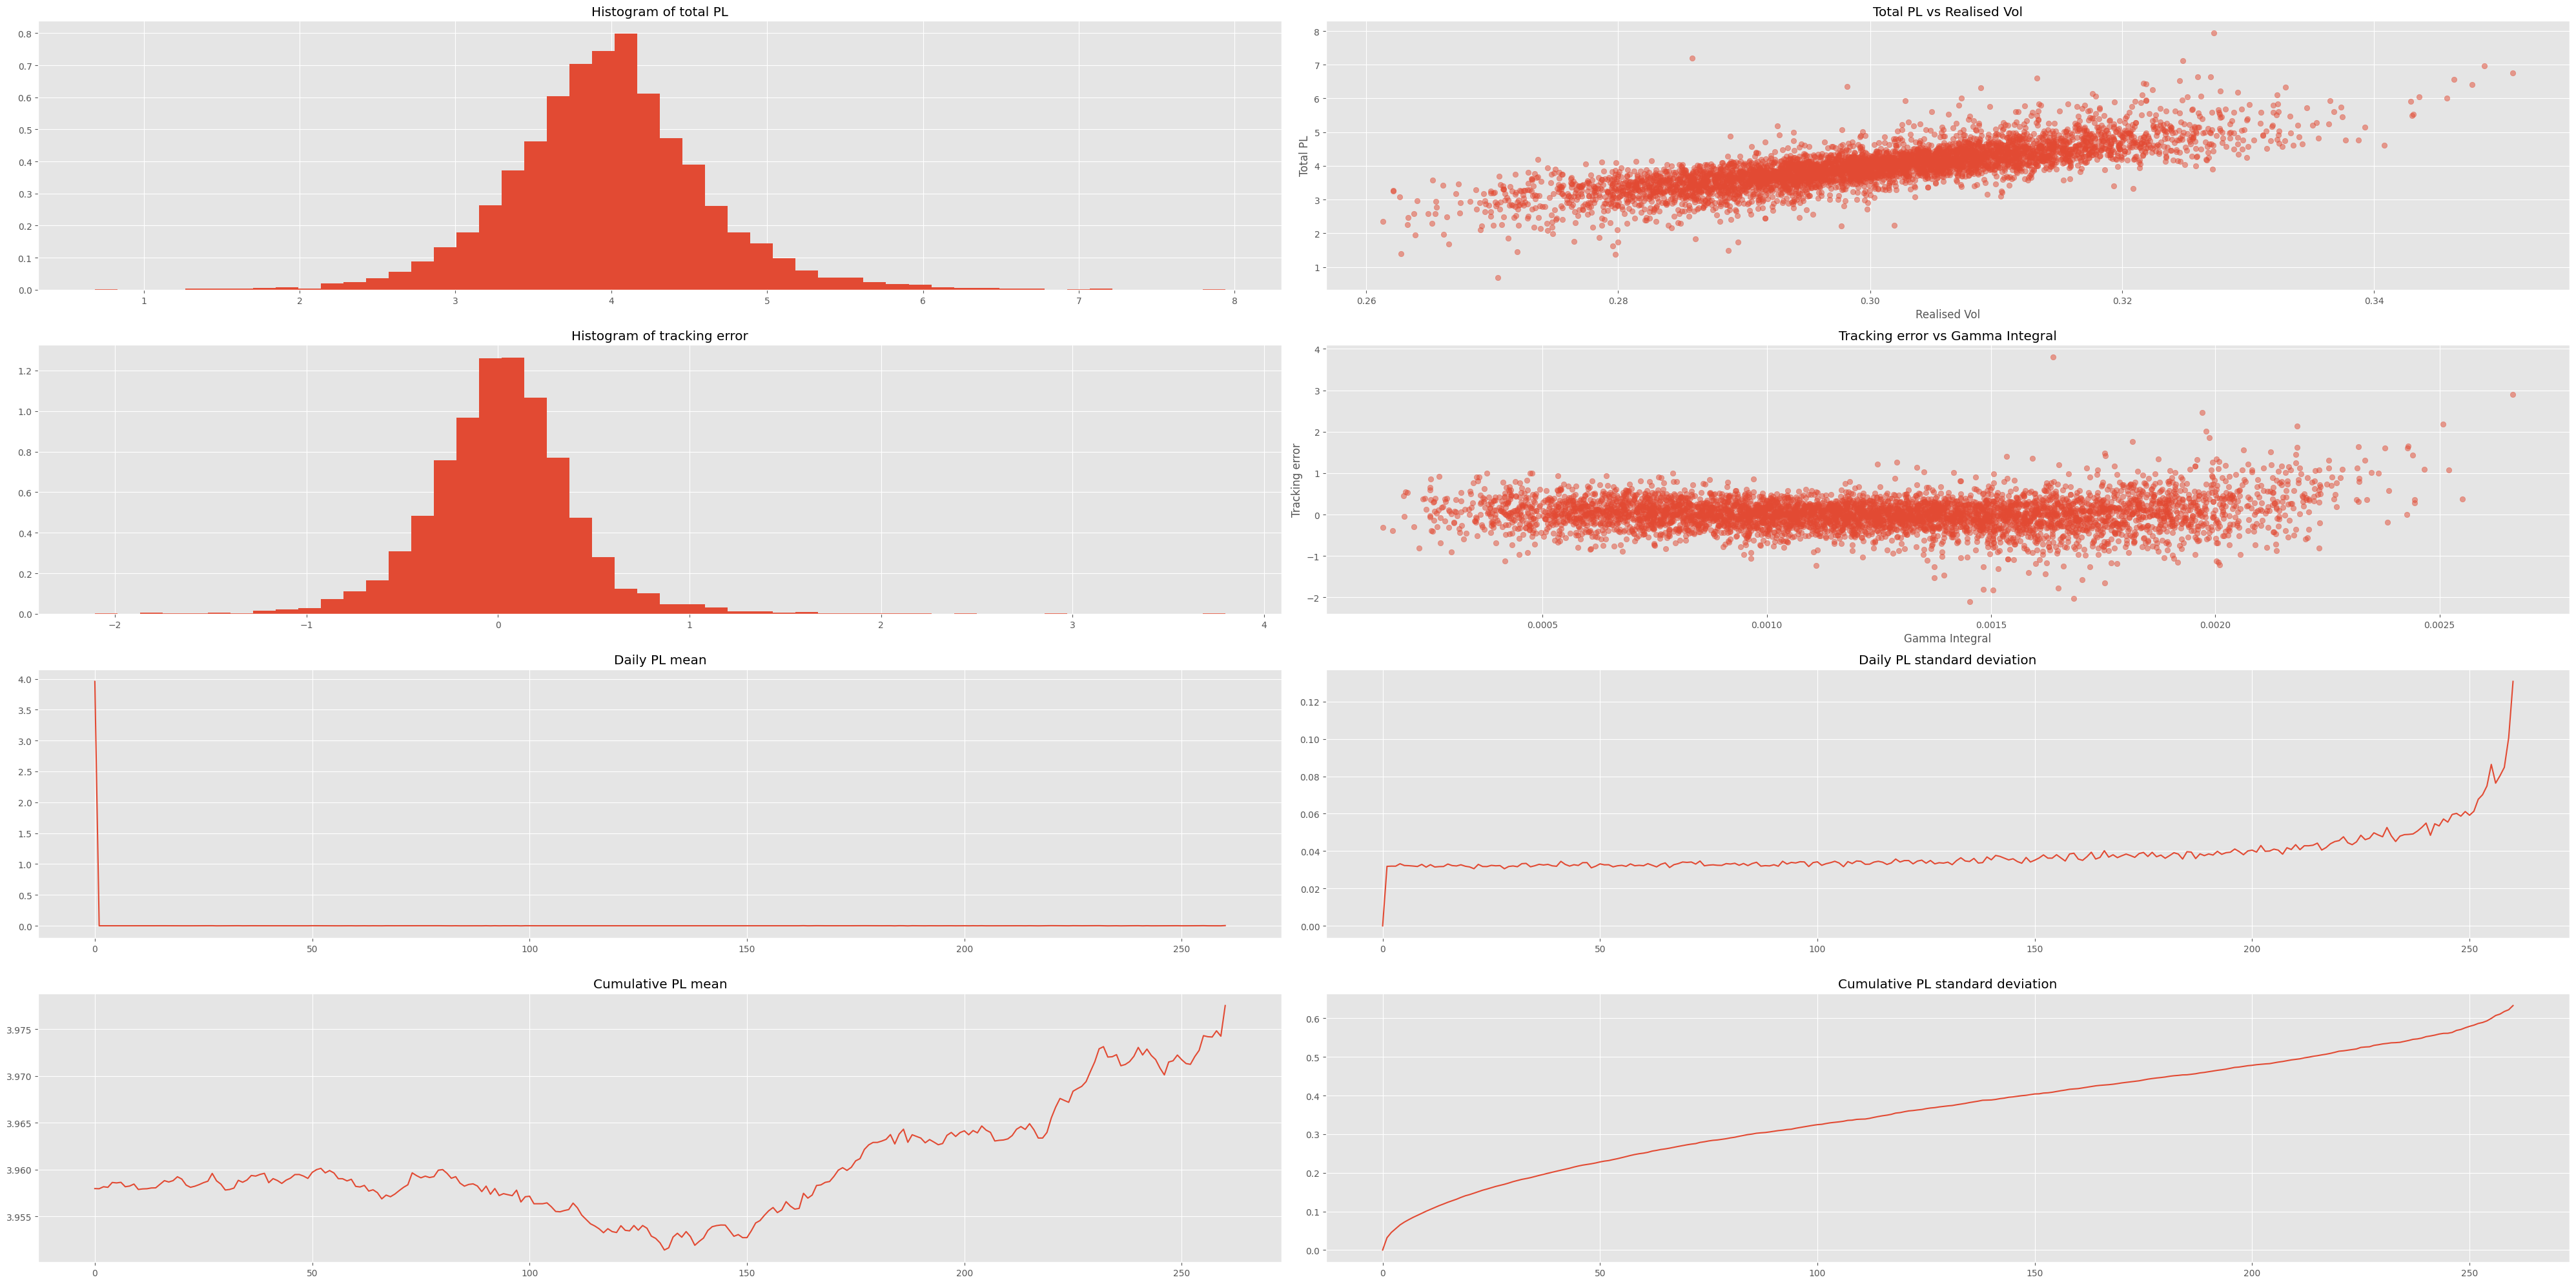

In [34]:
# Implied volatility is higher than sigma
implied_vol = sigma - 0.1
# Option price at moment t0:
price = bsm_value(S_0, K, T, r, q, implied_vol, 0)
# Delta hedge strategy:
cash_flows, values, deltas, gammas = delta_hedge_strategy(sample, K, T, r, q, sigma, sigma, 0, price)
# Benchmark PL:
benchmark_pl = bsm_value(S_0, K, T, r, q, realised_vol, 0) - bsm_value(S_0, K, T, r, q, implied_vol, 0)
# Plotting the results:
plot_stats(cash_flows, values, deltas, gammas, realised_vol, returns, benchmark_pl)

The picture is almost identical to the previous case. The only difference is extra positive PL recognised at t0 from purcahsing a mispriced option.

This is probably what volatility arbitrager would like to see but in reality market participants must value an option at market price rather than at their own theoretical price. Usually traders have more flexibility in their delta hedging than in their option valuation. In the next case we consider scenario where delta hedgers uses true $\sigma$ for delta hedging but values the option at implied volatility.

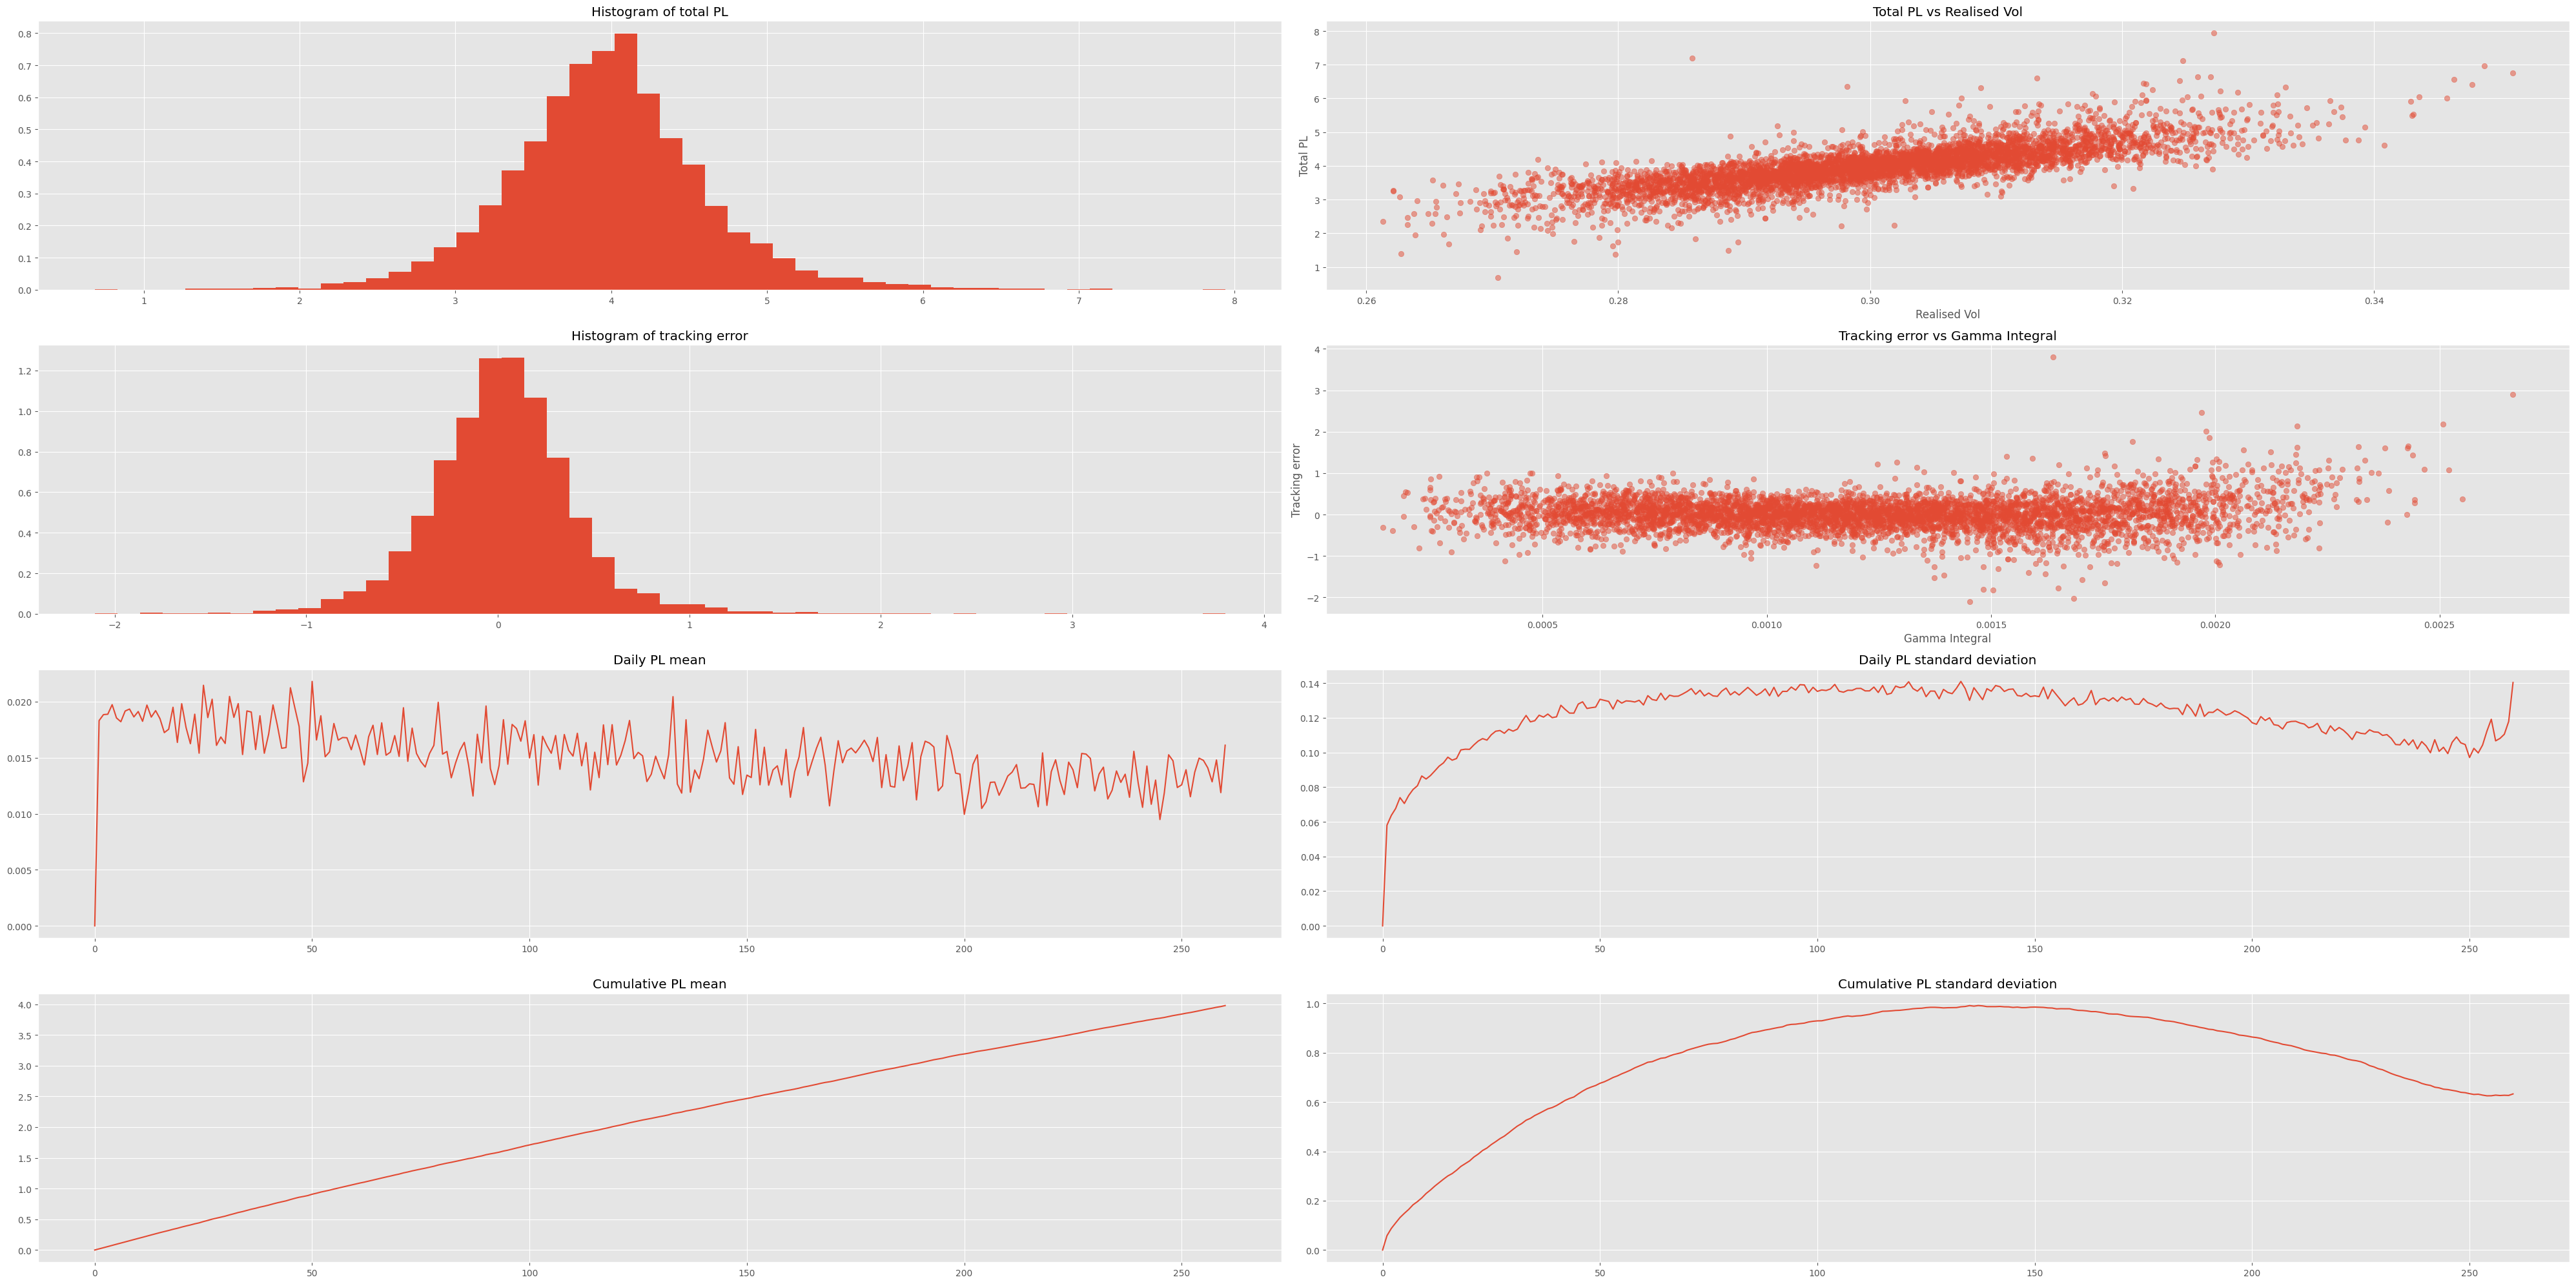

In [35]:
# Implicit volatility is higher than sigma
implied_vol = sigma - 0.1
# Delta hedge strategy assuming the trader is using true volaility for hedging:
cash_flows, values, deltas, gammas = delta_hedge_strategy(sample, K, T, r, q, implied_vol, sigma, 0)
# Benchmark PL:
benchmark_pl = bsm_value(S_0, K, T, r, q, realised_vol, 0) - bsm_value(S_0, K, T, r, q, implied_vol, 0)
# Plotting the results:
plot_stats(cash_flows, values, deltas, gammas, realised_vol, returns, benchmark_pl)

Here the difference with the previous case is that positive PL is recognised gradually over the lifetime of the option. Risk measured as standard deviation if daily PL is also higher than in the previous case. It can be expained by the fact valuation is not consistent with delta hedging strategy and true SDE of the asset price.

Next case is the most realistic. Delta hedger does not know the true volatility and uses implied volatility for both delta hedging and valuation of the option.

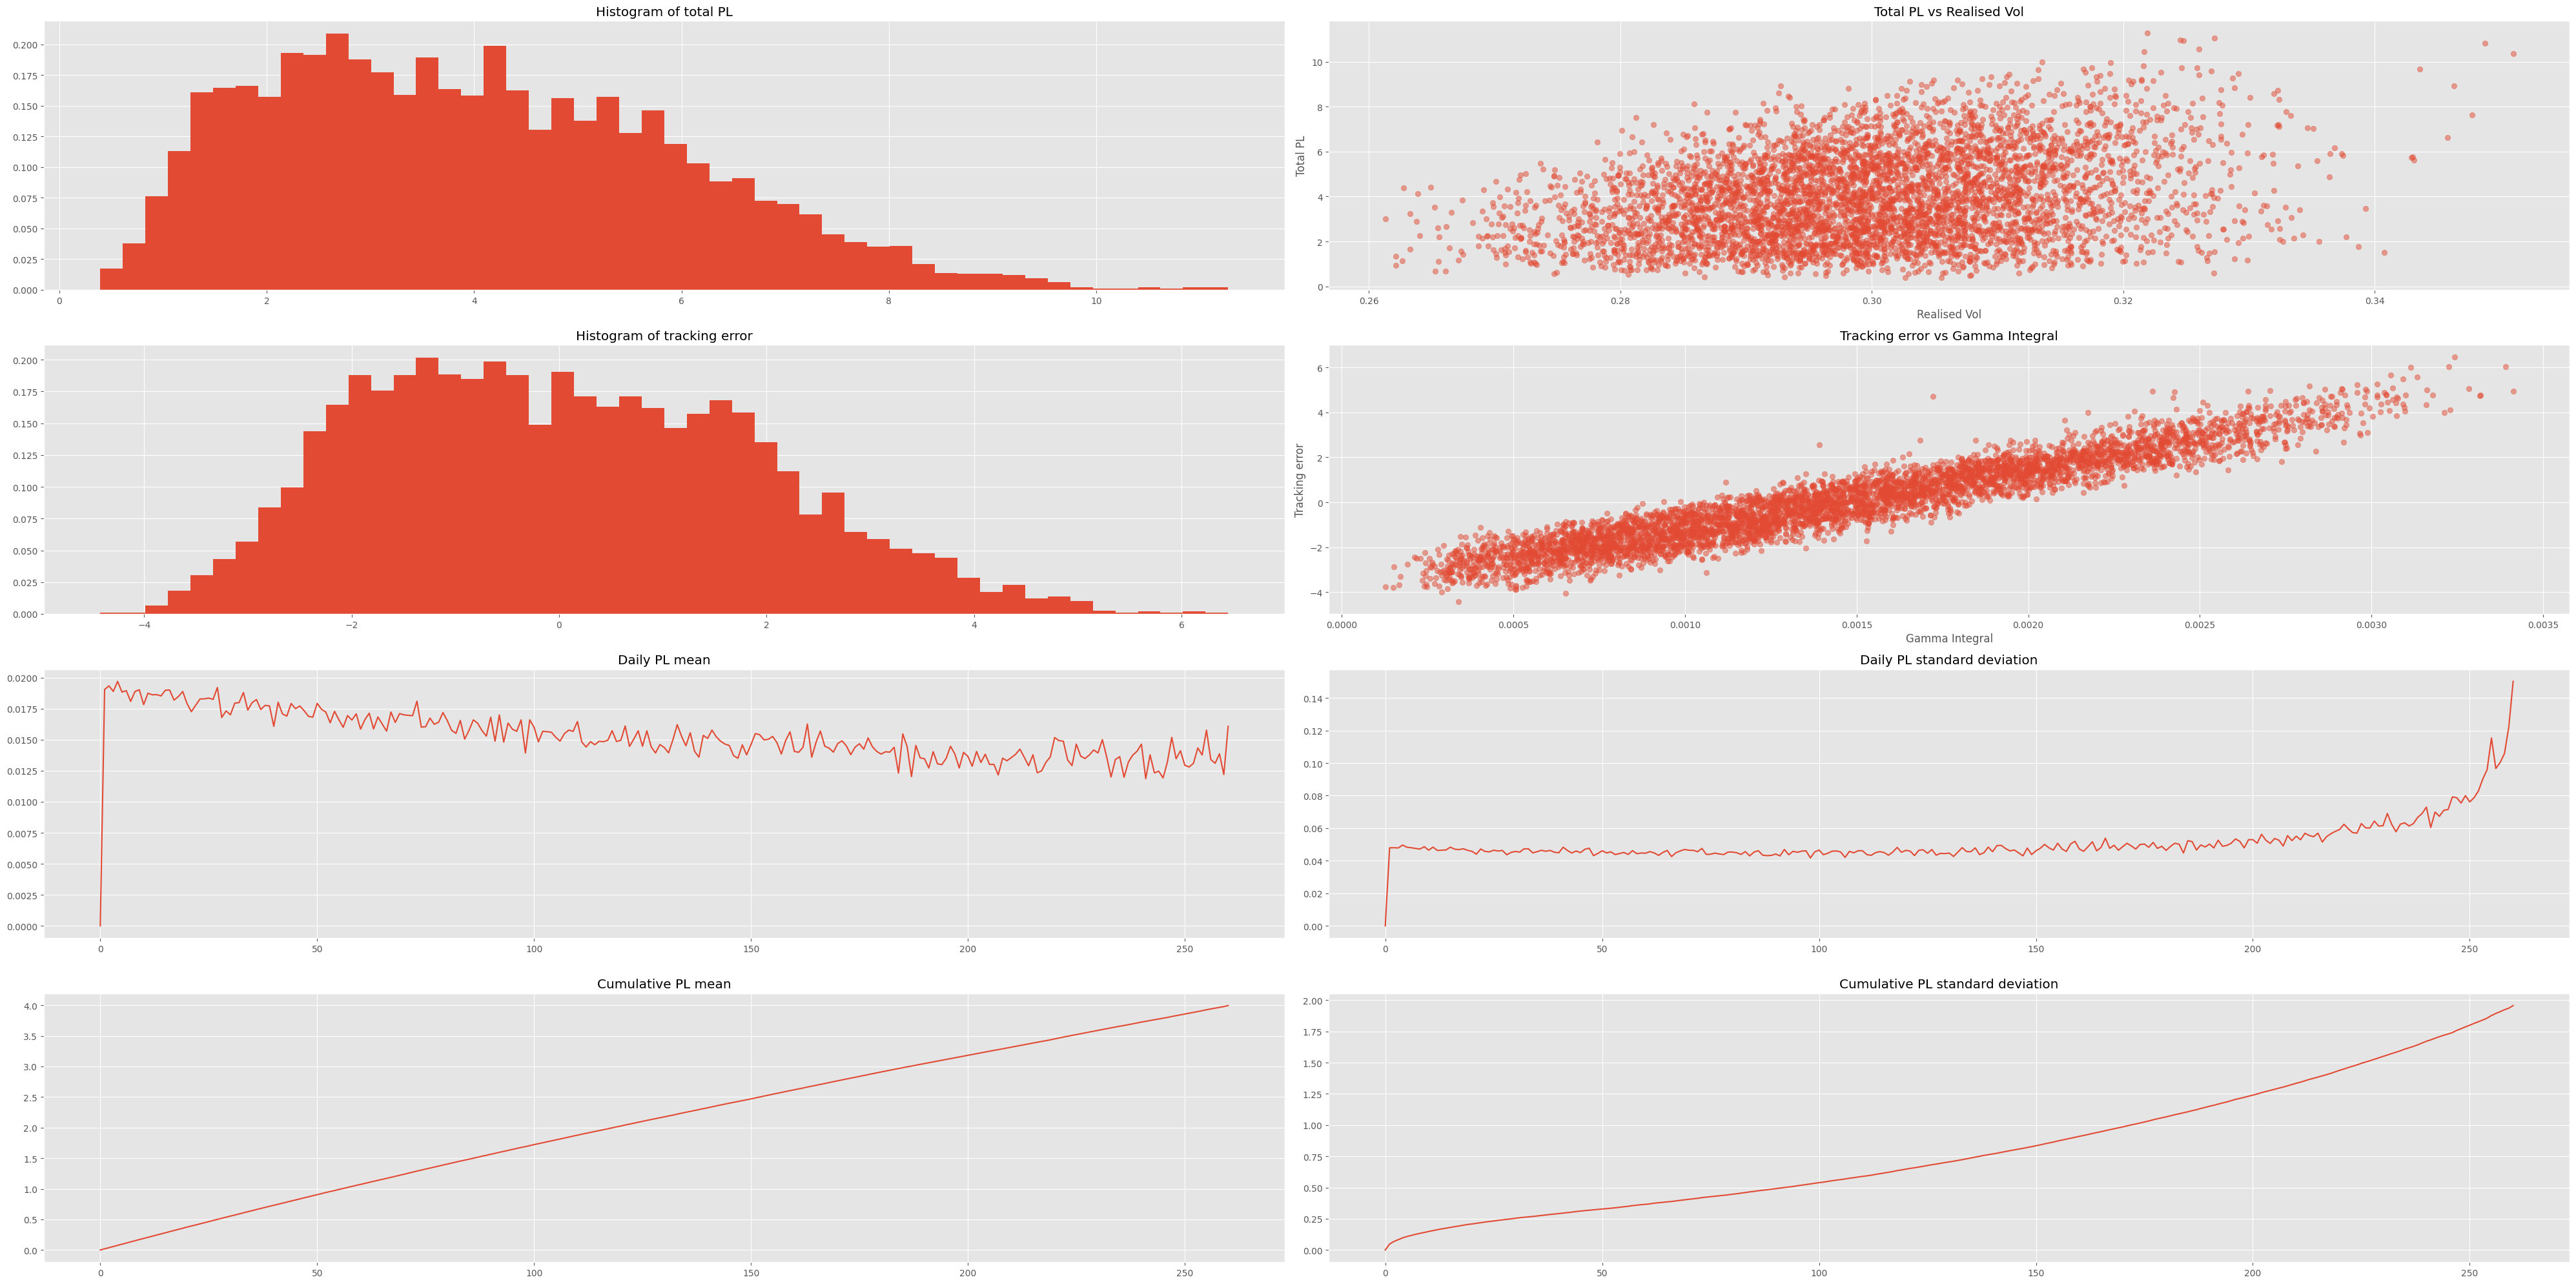

In [36]:
# Implied volatility is lower than sigma
implied_vol = sigma - 0.1
# Delta hedge strategy:
cash_flows, values, deltas, gammas = delta_hedge_strategy(sample, K, T, r, q, implied_vol, implied_vol, 0)
# Benchmark PL:
benchmark_pl = bsm_value(S_0, K, T, r, q, realised_vol, 0) - bsm_value(S_0, K, T, r, q, implied_vol, 0)
# Plotting the results:
plot_stats(cash_flows, values, deltas, gammas, realised_vol, returns, benchmark_pl)

The picture is more complicated in this case. PL distribution is wider and less normal. Apart from the reslised volatility, the PL is driven by the integral of gamma over the lifetime of the option. In other words, the strategy becomes path dependent. As in previous case PL accumulates gradually over the lifetime of the option. The risk is also higher than in the previous cases.